# Access harmonized LUCAS samples
First of all, let's import `st_lucas` library.

In [1]:
# To work with local st_lucas code
import sys
sys.path.append('../../')

from st_lucas import LucasRequest, LucasIO

## Usage

### 1. Define a request

Request is defined by the `LucasRequest` object. A bounding box filter can be enabled by the `bbox` property. Currently, only [EPSG:3035](http://epsg.io/3035) is supported.

For testing purposes, the request can be created by `build()` method.

In [2]:
request = LucasRequest()
request.bbox = (4504276, 3020369, 4689608, 3105290)

request.build()

{'typename': 'lucas:lucas_points',
 'filter': '<ogc:BBOX xmlns:gml311="http://www.opengis.net/gml" xmlns:ogc="http://www.opengis.net/ogc"><ogc:PropertyName>geom</ogc:PropertyName><gml311:Envelope srsName="http://www.opengis.net/gml/srs/epsg.xml#3035"><gml311:lowerCorner>4504276 3020369</gml311:lowerCorner><gml311:upperCorner>4689608 3105290</gml311:upperCorner></gml311:Envelope></ogc:BBOX>'}

### 2. Download data based on a request

LUCAS data are controlled by the `LucasIO` (input/output) class. Data are downloaded by calling the `download()` method using on the prepared request. The number of downloaded features can be retrived by the `num_of_features()` method.

In [3]:
lucasio = LucasIO()
lucasio.download(request)

print("Number of downloaded points:", lucasio.count())

2022-06-09 11:08:06,669 - LUCAS - INFO - io.__init__ - Using owslib version 0.22.0
2022-06-09 11:08:06,894 - LUCAS - INFO - io.download - Connected to https://geoforall.fsv.cvut.cz/st_lucas/geoserver/wfs
2022-06-09 11:08:06,896 - LUCAS - INFO - io.download - Request: {'srsname': 'http://www.opengis.net/gml/srs/epsg.xml#3035', 'typename': 'lucas:lucas_points', 'filter': '<ogc:BBOX xmlns:gml311="http://www.opengis.net/gml" xmlns:ogc="http://www.opengis.net/ogc"><ogc:PropertyName>geom</ogc:PropertyName><gml311:Envelope srsName="http://www.opengis.net/gml/srs/epsg.xml#3035"><gml311:lowerCorner>4504276 3020369</gml311:lowerCorner><gml311:upperCorner>4689608 3105290</gml311:upperCorner></gml311:Envelope></ogc:BBOX>'}
2022-06-09 11:08:07,673 - LUCAS - INFO - io.download - Download process successfuly finished. Size of downloaded data: 14257kb
Number of downloaded points: 5222


### 3. Get data in specified format

`LucasIO` object allows getting data in various data structures/formats.

By calling the `to_geopandas()` method, the data are retrieved as a [GeoDataFrame](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.html) object.

The method `to_gml()` returns a byte array containing data in the [OGC GML](https://www.ogc.org/standards/gml) format.

In [4]:
gml_str = lucasio.to_gml()

# check the type of the string
print(type(gml_str), '\n'.join(gml_str.splitlines()[:5]))

<class 'str'> <?xml version="1.0" encoding="utf-8" ?>
<ogr:FeatureCollection
     gml:id="aFeatureCollection"
     xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
     xsi:schemaLocation="http://ogr.maptools.org/ st_lucas_2uewhps1.xsd"


The method `to_gpkg()` stores the data in a [OGC GeoPackage](https://www.geopackage.org/) file.

In [5]:
gpkg_file = 'sample.gpkg'
lucasio.to_gpkg(gpkg_file)

# check if the file exists
from pathlib import Path
print(Path(gpkg_file).exists())

True


## Request examples

Beside filtering by the `bbox` property, `LucasRequest` also supports other methods described below.

### Filter by property

The filter below is equivalent to a `WHERE` condition:

```sql
nuts0 = 'CZ'
```

In [6]:
#from owslib.fes import PropertyIsEqualTo, Or

request = LucasRequest() 
request.countries = ['CZ']

request.build()

{'typename': 'lucas:lucas_points',
 'filter': '<ogc:PropertyIsEqualTo xmlns:ogc="http://www.opengis.net/ogc"><ogc:PropertyName>nuts0</ogc:PropertyName><ogc:Literal>CZ</ogc:Literal></ogc:PropertyIsEqualTo>'}

#### Logical operators

A logical operator is demostrated in the example below.

```sql
nuts0 = 'CZ' or nuts0 = 'SK'
```

In [7]:
#from owslib.fes import PropertyIsEqualTo, Or

request = LucasRequest()
request.countries = ['CZ', 'SK']
#request.logical = Or

request.build()

{'typename': 'lucas:lucas_points',
 'filter': '<ogc:Or xmlns:ogc="http://www.opengis.net/ogc"><ogc:PropertyIsEqualTo><ogc:PropertyName>nuts0</ogc:PropertyName><ogc:Literal>CZ</ogc:Literal></ogc:PropertyIsEqualTo><ogc:PropertyIsEqualTo><ogc:PropertyName>nuts0</ogc:PropertyName><ogc:Literal>SK</ogc:Literal></ogc:PropertyIsEqualTo></ogc:Or>'}

### Filter by years

This filter is defined by the `years` property.

In [8]:
request = LucasRequest()
request.bbox = (4472010, 2838000, 4960000, 3112000)
request.years = [2006, 2009]

request.build()

{'typename': 'lucas:lucas_points',
 'filter': '<ogc:And xmlns:ogc="http://www.opengis.net/ogc"><ogc:BBOX><ogc:PropertyName>geom</ogc:PropertyName><gml311:Envelope xmlns:gml311="http://www.opengis.net/gml" srsName="http://www.opengis.net/gml/srs/epsg.xml#3035"><gml311:lowerCorner>4472010 2838000</gml311:lowerCorner><gml311:upperCorner>4960000 3112000</gml311:upperCorner></gml311:Envelope></ogc:BBOX><ogc:Or><ogc:PropertyIsEqualTo><ogc:PropertyName>survey_year</ogc:PropertyName><ogc:Literal>2006</ogc:Literal></ogc:PropertyIsEqualTo><ogc:PropertyIsEqualTo><ogc:PropertyName>survey_year</ogc:PropertyName><ogc:Literal>2009</ogc:Literal></ogc:PropertyIsEqualTo></ogc:Or></ogc:And>'}

A combination of a filter by a *property* and a *year* is demonstrated below

```sql
(nuts0 = 'CZ' or nuts0 = 'SK') and (survey_year = 2006 or survey_year = 2009)
```

In [9]:
# from owslib.fes import PropertyIsEqualTo, Or

request = LucasRequest()
request.countries = ['CZ', 'SK']
#request.logical = Or

request.years = [2006, 2009]

request.build()

{'typename': 'lucas:lucas_points',
 'filter': '<ogc:And xmlns:ogc="http://www.opengis.net/ogc"><ogc:Or><ogc:PropertyIsEqualTo><ogc:PropertyName>nuts0</ogc:PropertyName><ogc:Literal>CZ</ogc:Literal></ogc:PropertyIsEqualTo><ogc:PropertyIsEqualTo><ogc:PropertyName>nuts0</ogc:PropertyName><ogc:Literal>SK</ogc:Literal></ogc:PropertyIsEqualTo></ogc:Or><ogc:Or><ogc:PropertyIsEqualTo><ogc:PropertyName>survey_year</ogc:PropertyName><ogc:Literal>2006</ogc:Literal></ogc:PropertyIsEqualTo><ogc:PropertyIsEqualTo><ogc:PropertyName>survey_year</ogc:PropertyName><ogc:Literal>2009</ogc:Literal></ogc:PropertyIsEqualTo></ogc:Or></ogc:And>'}

### Filter by AOI

Spatial filter can be also defined by polygon vertices. 

There is a limit for the request length, so the number of vertices is also limited. The AOI polygon can contain only about 190 vertices.

In [10]:
request = LucasRequest()
request.aoi_polygon = '<Within>' \
                  '     <PropertyName>lucas:geom</PropertyName>' \
                  '     <gml:Polygon xmlns:gml="http://www.opengis.net/gml" srsName="urn:ogc:def:crs:EPSG::3035" gml:id="polygon_32.geom.0">' \
                  '         <gml:exterior>' \
                  '             <gml:LinearRing>' \
                  '                 <gml:posList>3014669.3195414557 4640226.080241454 2981893.140187475 4628385.701013993 2965449.7283930806 4639492.816821902 2958781.6185918115 4658392.1858341275 2977549.274784839 4672892.4477362465 3004572.819247867 4661017.510044226 3014669.3195414557 4640226.080241454 </gml:posList>' \
                  '             </gml:LinearRing>' \
                  '         </gml:exterior>' \
                  '     </gml:Polygon>' \
                  '</Within>'

request.build()

{'typename': 'lucas:lucas_points',
 'filter': '<Within>     <PropertyName>lucas:geom</PropertyName>     <gml:Polygon xmlns:gml="http://www.opengis.net/gml" srsName="urn:ogc:def:crs:EPSG::3035" gml:id="polygon_32.geom.0">         <gml:exterior>             <gml:LinearRing>                 <gml:posList>3014669.3195414557 4640226.080241454 2981893.140187475 4628385.701013993 2965449.7283930806 4639492.816821902 2958781.6185918115 4658392.1858341275 2977549.274784839 4672892.4477362465 3004572.819247867 4661017.510044226 3014669.3195414557 4640226.080241454 </gml:posList>             </gml:LinearRing>         </gml:exterior>     </gml:Polygon></Within>'}

### Groups

A group determines which attributes will describe the downloaded data. There are 5 groups (`CO` - Copernicus; `FO` - Forestry; `IN` - INSPIRE; `LC_LU` - Land cover, Land use; `LC_LU_SO` - Land cover, Land use, Soil). 

The file always contains mandatory attributes that define mainly the location of the point.

A combination of `bbox` and `group` (Land cover, Land use) is presented below.

In [11]:
request = LucasRequest()
request.bbox = (4504276, 3020369, 4689608, 3105290)
request.group = 'LC_LU'

request.build()

{'typename': 'lucas:lucas_points_lc_lu',
 'filter': '<ogc:BBOX xmlns:ogc="http://www.opengis.net/ogc"><ogc:PropertyName>geom</ogc:PropertyName><gml311:Envelope xmlns:gml311="http://www.opengis.net/gml" srsName="http://www.opengis.net/gml/srs/epsg.xml#3035"><gml311:lowerCorner>4504276 3020369</gml311:lowerCorner><gml311:upperCorner>4689608 3105290</gml311:upperCorner></gml311:Envelope></ogc:BBOX>'}

### Space-time aggregation

The `st_aggregated` property is used to determine whether the data should be space-time aggregated. Space-time aggregation means that one record in the attribute table represents one point with all values measured in all years. Otherwise, every single record in the attribute table represents one survey.

#### A combination with a property filter

A combination of a property filter and a request for space-time aggregated data is presented below.

In [12]:
# from owslib.fes import PropertyIsEqualTo

request = LucasRequest()
request.countries = ['CZ']

request.st_aggregated = True

request.build()

{'typename': 'lucas:lucas_st_points',
 'filter': '<ogc:PropertyIsEqualTo xmlns:ogc="http://www.opengis.net/ogc"><ogc:PropertyName>nuts0</ogc:PropertyName><ogc:Literal>CZ</ogc:Literal></ogc:PropertyIsEqualTo>'}

#### With a filter by years and bbox

A combination of a filter by `years`, `bbox` and a request for `space-time aggregated` data.
The received data will be described only by the attributes measured in required years. This means that the attribute table will be smaller and clear.

In [13]:
request = LucasRequest()
request.years = [2015, 2018]

request.bbox=(4624127, 2998330, 4650393, 3013986)

request.st_aggregated = True

request.build()

{'typename': 'lucas:lucas_st_points',
 'filter': '<ogc:And xmlns:ogc="http://www.opengis.net/ogc"><ogc:BBOX><ogc:PropertyName>geom</ogc:PropertyName><gml311:Envelope xmlns:gml311="http://www.opengis.net/gml" srsName="http://www.opengis.net/gml/srs/epsg.xml#3035"><gml311:lowerCorner>4624127 2998330</gml311:lowerCorner><gml311:upperCorner>4650393 3013986</gml311:upperCorner></gml311:Envelope></ogc:BBOX><ogc:Or><ogc:Not><ogc:PropertyIsNull><ogc:PropertyName>survey_date_2015</ogc:PropertyName></ogc:PropertyIsNull></ogc:Not><ogc:Not><ogc:PropertyIsNull><ogc:PropertyName>survey_date_2018</ogc:PropertyName></ogc:PropertyIsNull></ogc:Not></ogc:Or></ogc:And>'}

### Show photos of selected LUCAS point

#### Show point_id of points by geopandas

In [14]:
df = lucasio.to_geopandas()
df[["point_id"]]

,point_id
0,46723026
1,45923022
2,45963044
3,45663060
4,45063058
...,...
5217,45123104
5218,45443074
5219,46423082
5220,46063102


#### Display photos

Show photos of a selected LUCAS point by calling the method `get_images()` with `year` and `point_id` of the point specified. This will return a dictionary of URL adresses of 5 photos representing the point itself, a northern look, a southern look, an eastern look, and a western look.

In [15]:
id = df[["point_id"]].values[0][0]
images = lucasio.get_images(2012, id)
print(images)

{'P': 'https://gisco-services.ec.europa.eu/lucas/photos/2012/CZ/467/230/46723026P.jpg', 'S': 'https://gisco-services.ec.europa.eu/lucas/photos/2012/CZ/467/230/46723026S.jpg', 'N': 'https://gisco-services.ec.europa.eu/lucas/photos/2012/CZ/467/230/46723026N.jpg', 'E': 'https://gisco-services.ec.europa.eu/lucas/photos/2012/CZ/467/230/46723026E.jpg', 'W': 'https://gisco-services.ec.europa.eu/lucas/photos/2012/CZ/467/230/46723026W.jpg'}


Let's display photo representing the South of the point.

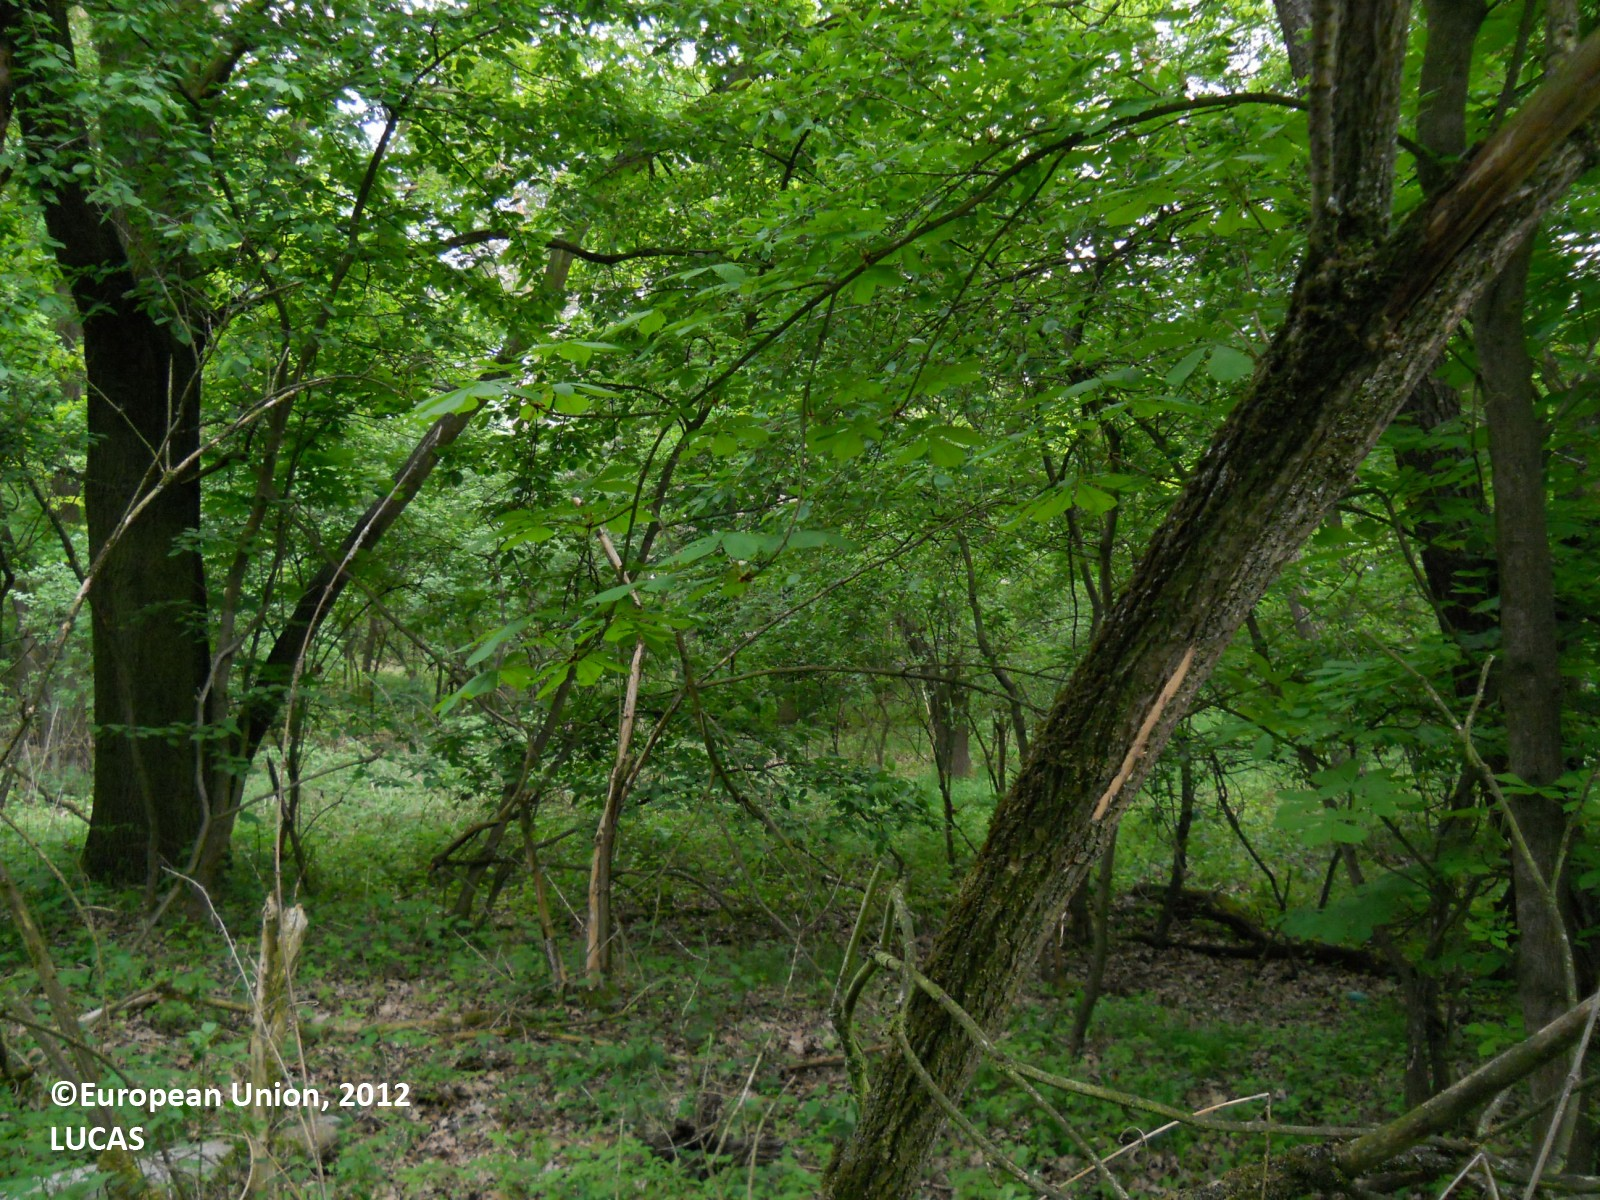

In [16]:
import requests
from IPython.display import Image

r = requests.get(images["S"])
Image(r.content)